In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation, RNN
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

Using TensorFlow backend.


(1000, 1)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


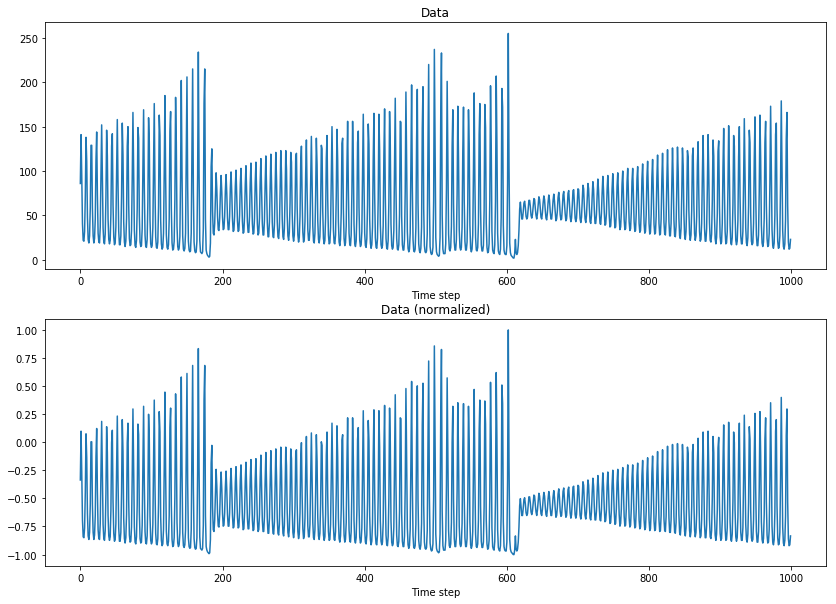

In [2]:
plt.figure(figsize=(14,10))
plt.subplot(211)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(212)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [3]:
inputsize = 300

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def get_model():
    model = keras.Sequential()
    model.add(LSTM(16, return_sequences=True, input_shape=(trainX.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(8, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss=root_mean_squared_error,
              optimizer='adam',
              metrics=['accuracy'])
    return model

# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))

# Compare normalized and not normalized data (data/data_normed)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

loadModel = True

if loadModel:
    model = keras.models.load_model("model.h5")
else:
    # Create model
    model = get_model()
    # Train it
    history = model.fit(trainX, trainY, epochs=30, validation_data=(testX, testY), verbose=2, shuffle=True)
    # Save it
    model.save("model.h5")

inputdata Shape (700, 300, 1)
target Shape (700, 1)
trainX.shape (630, 300, 1)
trainY.shape (630, 1)
testX.shape (70, 300, 1)
testY.shape (70, 1)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


pred.shape  (70, 1)


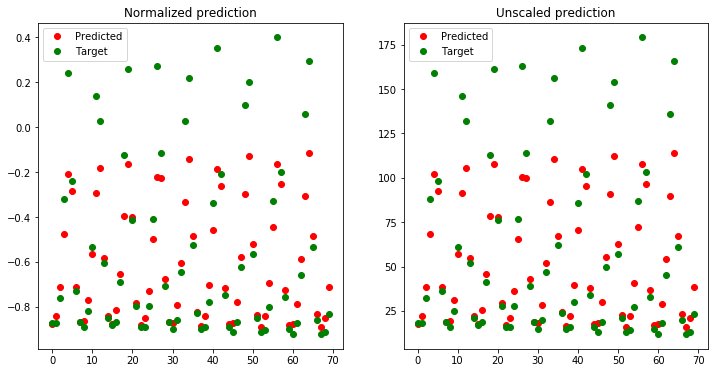

In [5]:
pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

if not loadModel:
    plt.title('Loss development')
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

## Predict a timeseries of 200 timesteps recursively

(630, 300, 1)


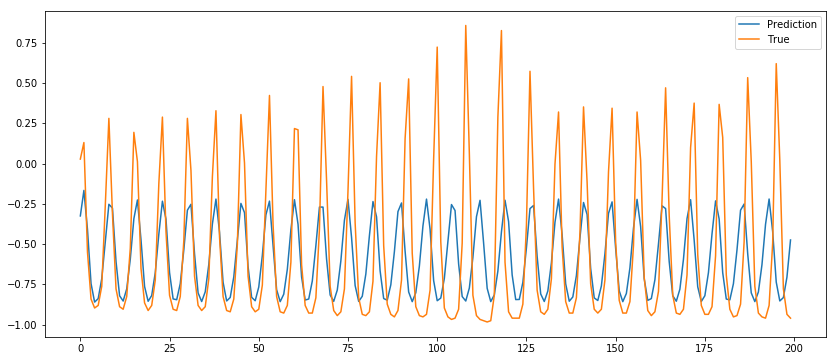

In [6]:
def forecast(model, inp, timesteps=200):
    for i in range(timesteps):
        # make forecast
        pred = model.predict(inp.reshape(1,len(inp),1))
#         print(pred)
        # add it and use it as new input
        inp = np.append(inp, pred)
        inp = inp[-inputsize:]
    return inp[-timesteps:]

print(trainX.shape)
i = 90
forecast_pred = forecast(model, trainX[i], 200)
true_forecast = trainX[i+200][-200:]
plt.figure(figsize=(14,6))
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()

## Try to implement K-Fold crossvalidation and save the n-best models to use as ensemble

In [7]:
def save_models(models):
    for i, m in enumerate(models):
        m.save(f"models/model{i}.h5")
    print("Saved models")

def load_models():
    files = os.listdir("models")
    models = []
    for f in files:
        print("Load model: ", f)
        loaded_model = keras.models.load_model(f"models/{f}")
        models.append(loaded_model)
    return models

loadModels = False

if loadModels:
    models = load_models()
else:
    models = []
    n_folds = 10
    kf = KFold(n_splits=n_folds)
    iteration = 0
    for train_index, test_index in kf.split(inputdata, target):
        trainX, trainY = inputdata[train_index], target[train_index]
        testX, testY = inputdata[test_index], target[test_index]

        # Create model
        model = get_model()
        # Train it
        history = model.fit(trainX, trainY, epochs=30, validation_split=0.1, verbose=2)
        # Save it
        model.save(f"models/model{iteration}.h5")

        models.append(model)
        score = model.evaluate(testX, testY)[0]
        print(f'Iteration: {iteration} with score: {score}')
        iteration += 1

Train on 567 samples, validate on 63 samples
Epoch 1/30
 - 7s - loss: 0.3940 - acc: 0.0000e+00 - val_loss: 0.2913 - val_acc: 0.0000e+00
Epoch 2/30
 - 5s - loss: 0.1985 - acc: 0.0018 - val_loss: 0.1774 - val_acc: 0.0000e+00
Epoch 3/30
 - 5s - loss: 0.1565 - acc: 0.0035 - val_loss: 0.1827 - val_acc: 0.0000e+00
Epoch 4/30
 - 5s - loss: 0.1518 - acc: 0.0018 - val_loss: 0.1773 - val_acc: 0.0000e+00
Epoch 5/30
 - 5s - loss: 0.1395 - acc: 0.0000e+00 - val_loss: 0.1747 - val_acc: 0.0000e+00
Epoch 6/30
 - 5s - loss: 0.1395 - acc: 0.0035 - val_loss: 0.1734 - val_acc: 0.0000e+00
Epoch 7/30
 - 5s - loss: 0.1391 - acc: 0.0035 - val_loss: 0.1722 - val_acc: 0.0000e+00
Epoch 8/30
 - 5s - loss: 0.1343 - acc: 0.0035 - val_loss: 0.1734 - val_acc: 0.0000e+00
Epoch 9/30
 - 5s - loss: 0.1385 - acc: 0.0035 - val_loss: 0.1718 - val_acc: 0.0000e+00
Epoch 10/30
 - 5s - loss: 0.1347 - acc: 0.0035 - val_loss: 0.1709 - val_acc: 0.0000e+00
Epoch 11/30
 - 5s - loss: 0.1340 - acc: 0.0018 - val_loss: 0.1715 - val_acc:

70/70 [==============================] - 0s 2ms/step
Iteration: 2 with score: 0.27191483208111356
Train on 567 samples, validate on 63 samples
Epoch 1/30
 - 8s - loss: 0.1914 - acc: 0.0018 - val_loss: 0.1793 - val_acc: 0.0000e+00
Epoch 2/30
 - 5s - loss: 0.1397 - acc: 0.0035 - val_loss: 0.1860 - val_acc: 0.0000e+00
Epoch 3/30
 - 5s - loss: 0.1305 - acc: 0.0035 - val_loss: 0.1771 - val_acc: 0.0000e+00
Epoch 4/30
 - 5s - loss: 0.1281 - acc: 0.0035 - val_loss: 0.1753 - val_acc: 0.0000e+00
Epoch 5/30
 - 5s - loss: 0.1272 - acc: 0.0018 - val_loss: 0.1749 - val_acc: 0.0000e+00
Epoch 6/30
 - 5s - loss: 0.1228 - acc: 0.0035 - val_loss: 0.1743 - val_acc: 0.0000e+00
Epoch 7/30
 - 5s - loss: 0.1223 - acc: 0.0018 - val_loss: 0.1738 - val_acc: 0.0000e+00
Epoch 8/30
 - 5s - loss: 0.1218 - acc: 0.0035 - val_loss: 0.1737 - val_acc: 0.0000e+00
Epoch 9/30
 - 5s - loss: 0.1217 - acc: 0.0035 - val_loss: 0.1742 - val_acc: 0.0000e+00
Epoch 10/30
 - 5s - loss: 0.1235 - acc: 0.0035 - val_loss: 0.1731 - val_ac

Epoch 28/30
 - 5s - loss: 0.0987 - acc: 0.0000e+00 - val_loss: 0.0607 - val_acc: 0.0000e+00
Epoch 29/30
 - 5s - loss: 0.0822 - acc: 0.0000e+00 - val_loss: 0.0421 - val_acc: 0.0000e+00
Epoch 30/30
 - 5s - loss: 0.0762 - acc: 0.0000e+00 - val_loss: 0.0304 - val_acc: 0.0000e+00
70/70 [==============================] - 0s 2ms/step
Iteration: 5 with score: 0.009641166736504862
Train on 567 samples, validate on 63 samples
Epoch 1/30
 - 9s - loss: 0.2614 - acc: 0.0000e+00 - val_loss: 0.2088 - val_acc: 0.0000e+00
Epoch 2/30
 - 5s - loss: 0.1894 - acc: 0.0018 - val_loss: 0.1823 - val_acc: 0.0000e+00
Epoch 3/30
 - 5s - loss: 0.1652 - acc: 0.0018 - val_loss: 0.1794 - val_acc: 0.0000e+00
Epoch 4/30
 - 5s - loss: 0.1564 - acc: 0.0035 - val_loss: 0.1768 - val_acc: 0.0000e+00
Epoch 5/30
 - 5s - loss: 0.1477 - acc: 0.0035 - val_loss: 0.1757 - val_acc: 0.0000e+00
Epoch 6/30
 - 5s - loss: 0.1470 - acc: 0.0018 - val_loss: 0.1744 - val_acc: 0.0000e+00
Epoch 7/30
 - 5s - loss: 0.1460 - acc: 0.0000e+00 - va

KeyboardInterrupt: 

> 1: single=0.070, ensemble=0.070
> 2: single=0.063, ensemble=0.066
> 3: single=0.067, ensemble=0.064
> 4: single=0.068, ensemble=0.066
> 5: single=0.062, ensemble=0.064
> 6: single=0.012, ensemble=0.063
> 7: single=0.065, ensemble=0.064
MSE 0.058 (0.019)


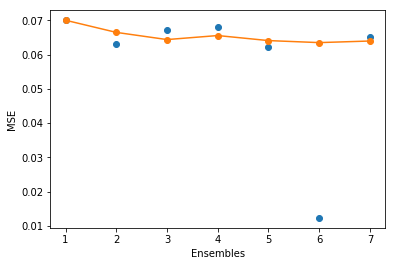

In [8]:
def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    # median across ensemble members
    result = np.median(yhats, axis=0)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(models, n_models, testX, testy):
    # select a subset of members
    subset = models[:n_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return mean_squared_error(testy, yhat)

def forecast_ensemble(models, inp, timesteps=200):
    for i in range(timesteps):
        # make forecast
        pred = ensemble_predictions(models, inp.reshape(1,len(inp),1))
        # add it and use it as new input
        inp = np.append(inp, pred)
        inp = inp[-inputsize:]
    return inp[-timesteps:]
    
# save_models(models)
# models = load_models()

validationX, validationY = testX, testY
single_MSEs, ensemble_MSEs = [], []
for i in range(1, len(models)+1):
    ensemble_MSE = evaluate_n_members(models, i, validationX, validationY)
    single_MSE, _ = models[i-1].evaluate(validationX, validationY, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_MSE, ensemble_MSE))
    ensemble_MSEs.append(ensemble_MSE)
    single_MSEs.append(single_MSE)
# plot score vs number of ensemble members
print('MSE %.3f (%.3f)' % (np.mean(single_MSEs), np.std(single_MSEs)))
x_axis = [i for i in range(1, len(models)+1)]
plt.plot(x_axis, single_MSEs, marker='o', linestyle='None', label='Single model')
plt.plot(x_axis, ensemble_MSEs, marker='o', label="Ensemble")
plt.ylabel('MSE')
plt.xlabel('Ensembles')
plt.show()


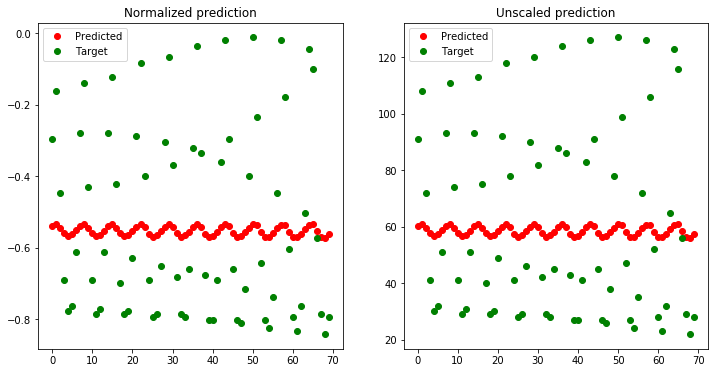

MSE:  0.06552790083859877


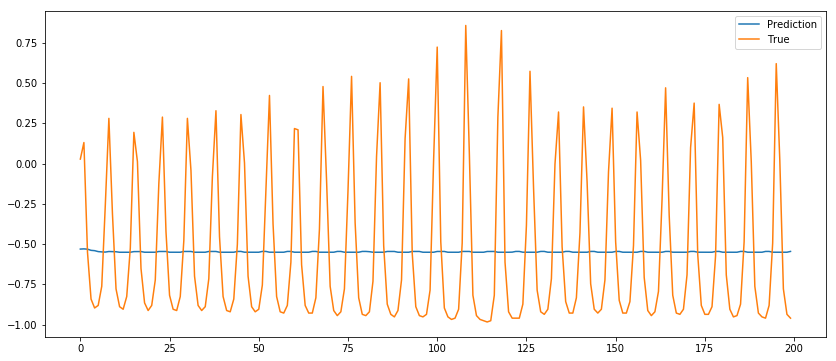

In [9]:
pred = ensemble_predictions(models[:4], testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

print("MSE: ", mean_squared_error(testY, pred))

i = 90
forecast_pred = forecast_ensemble(models, trainX[i], 200)
true_forecast = trainX[i+200][-200:]
plt.figure(figsize=(14,6))
plt.plot(forecast_pred, label='Prediction')
plt.plot(true_forecast, label='True')
plt.legend()
plt.show()